In [1]:
from pyuvdata import UVCal
import pyuvdata.utils as uvutils
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly
import os

In [2]:
fhd_folder = "/Users/bryna/Projects/Physics/data_files/van_vleck_runs/fhd_van_vleck_corr_ver7_40khzedgeflagged/"
obsname = "1061315448_vv_cable_phase_gains_cb_40khzedgeflagged_80kHz_2s"
cal_file = os.path.join(fhd_folder, "calibration", obsname + "_cal.sav")
obs_file = os.path.join(fhd_folder, "metadata", obsname + "_obs.sav")
layout_file = os.path.join(fhd_folder, "metadata", obsname + "_layout.sav")
settings_file = os.path.join(fhd_folder, "metadata", obsname + "_settings.txt")

In [3]:
calobj = UVCal()
calobj.read_fhd_cal(cal_file, obs_file, settings_file=settings_file)
freq_array_mhz = np.squeeze(calobj.freq_array*1e-6)

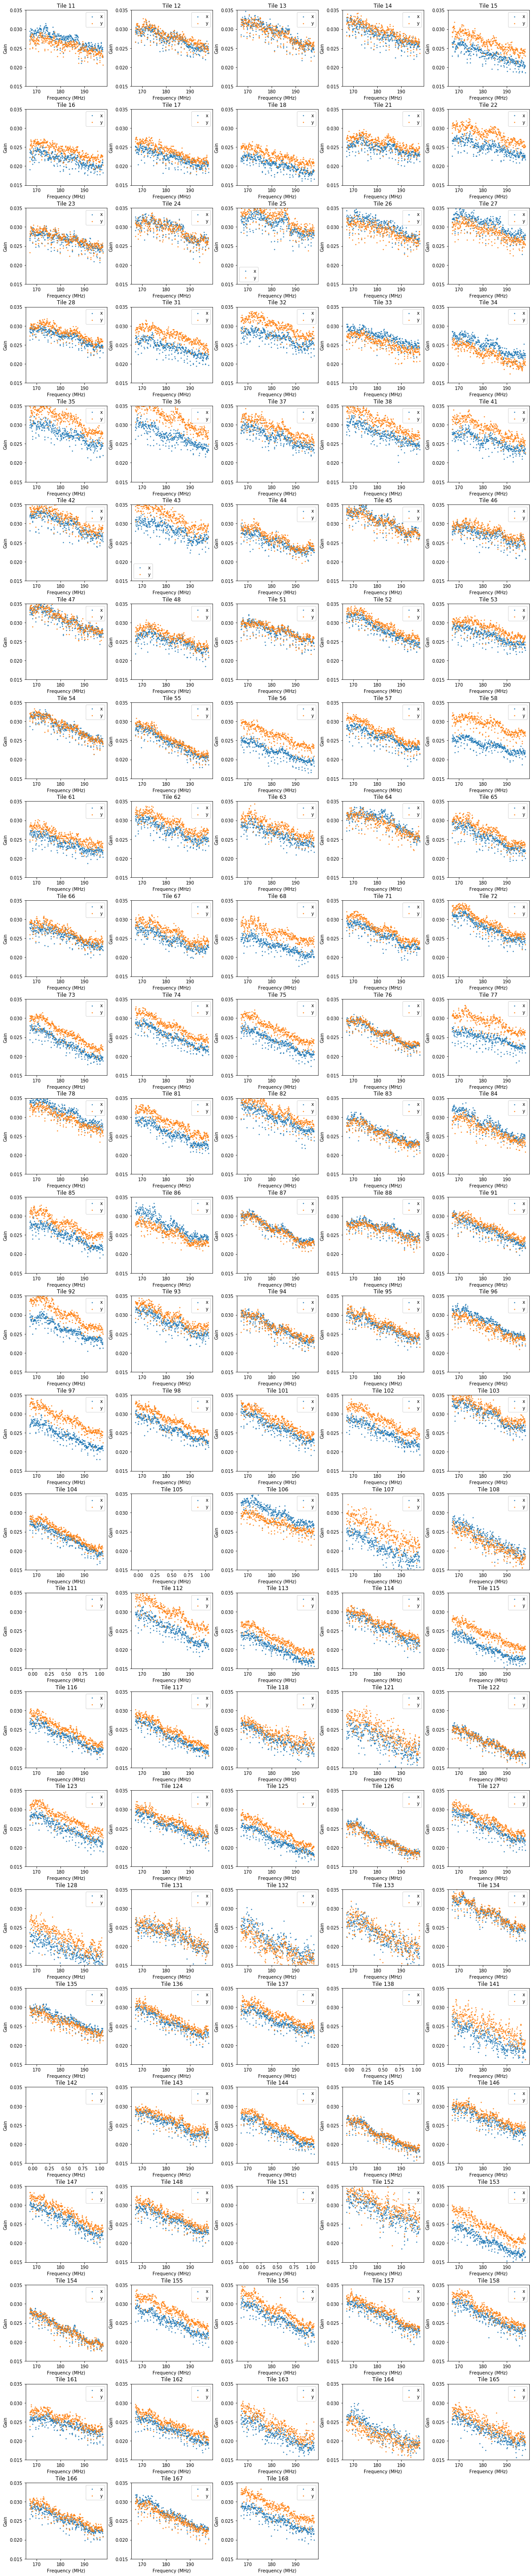

In [11]:
savefig = False

if savefig:
    columns = 10
    rows = np.ceil(calobj.Nants_data / columns)    
else:
    columns = 5
    rows = np.ceil(calobj.Nants_data / columns)
plt.figure(figsize=(4*columns,4*rows))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace = 0.3)
polnames = uvutils.jnum2str(calobj.jones_array)

for ant_num, ant_name in zip(calobj.antenna_numbers, calobj.antenna_names):
    amplitude = np.ma.array(
        np.squeeze(np.abs(calobj.get_gains(ant_num))),
        mask = np.squeeze(np.abs(calobj.get_flags(ant_num)))
    )
    plt.subplot(rows, columns, ant_num+1)
    plt.scatter(freq_array_mhz, amplitude[:,0], label=polnames[0][-1], marker="o", s=2)
    plt.scatter(freq_array_mhz, amplitude[:,1], label=polnames[1][-1], marker="o", s=2)
    titlename = 'Tile ' + ant_name.strip()
    plt.title(titlename)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Gain")
    plt.ylim(0.015, 0.035)
    plt.legend()

if savefig:
    plt.savefig(os.path.join(fhd_folder, obsname + "_uvcal_gains.png"))

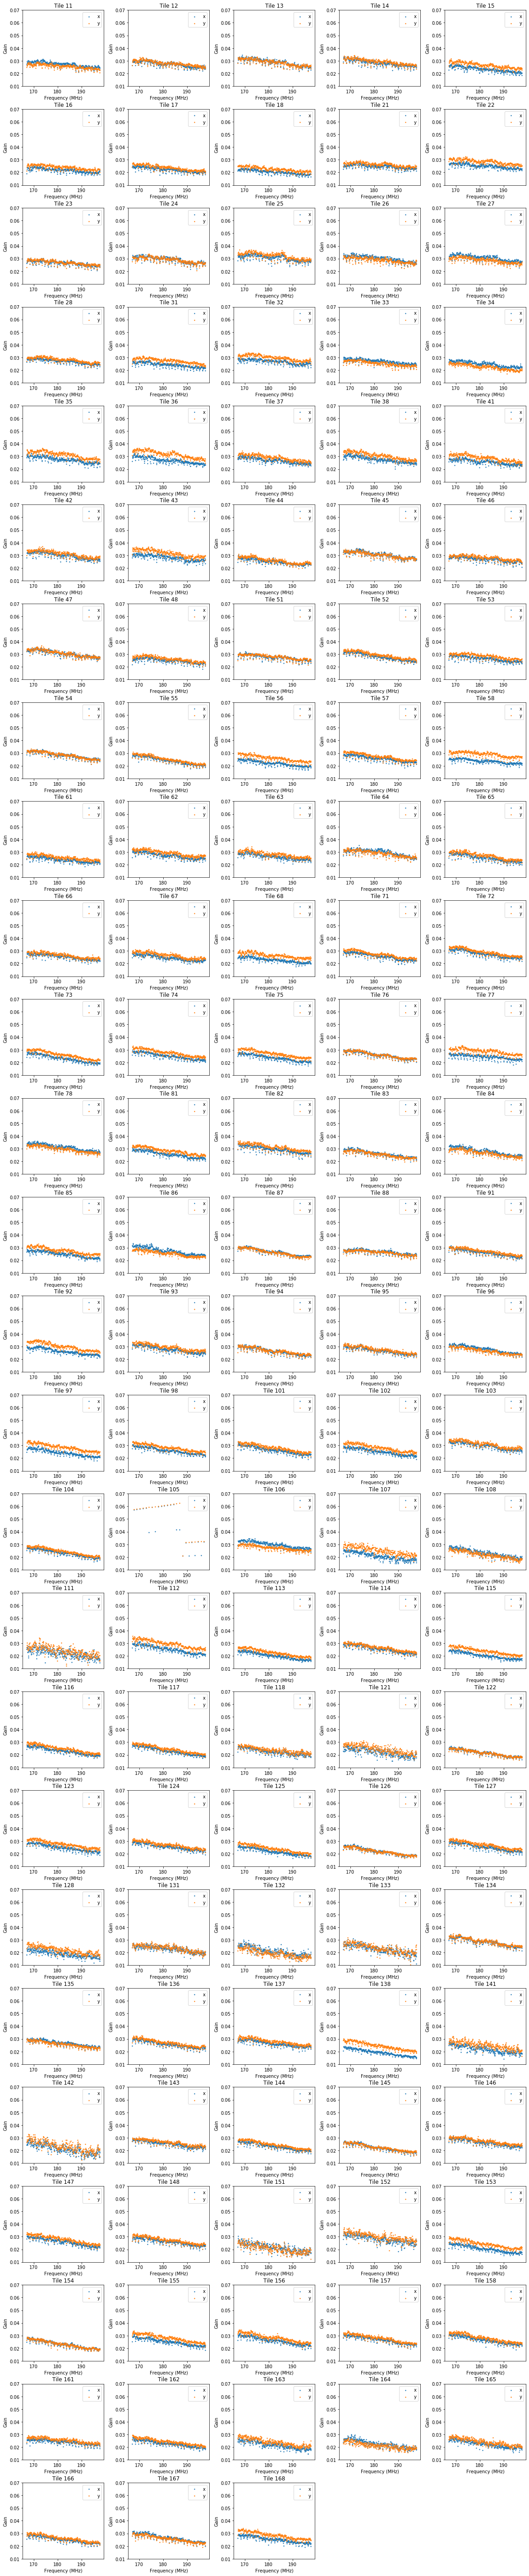

In [12]:
savefig = False

if savefig:
    columns = 10
    rows = np.ceil(calobj.Nants_data / columns)    
else:
    columns = 5
    rows = np.ceil(calobj.Nants_data / columns)
plt.figure(figsize=(4*columns,4*rows))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace = 0.3)
polnames = uvutils.jnum2str(calobj.jones_array)

for ant_num, ant_name in zip(calobj.antenna_numbers, calobj.antenna_names):
    amplitude = np.squeeze(np.abs(calobj.get_gains(ant_num)))
    plt.subplot(rows, columns, ant_num+1)
    plt.scatter(freq_array_mhz, amplitude[:,0], label=polnames[0][-1], marker="o", s=2)
    plt.scatter(freq_array_mhz, amplitude[:,1], label=polnames[1][-1], marker="o", s=2)
    titlename = 'Tile ' + ant_name.strip()
    plt.title(titlename)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Gain")
    plt.ylim(0.01, 0.07)
    plt.legend()

if savefig:
    plt.savefig(os.path.join(fhd_folder, obsname + "_uvcal_gains.png"))

In [6]:
calobj.gain_array.shape
mean_bandpass = np.ma.average(np.ma.array(
    np.squeeze(calobj.gain_array),
    mask = np.squeeze(calobj.flag_array)
), axis=0)
median_bandpass = np.ma.median(np.ma.array(
    np.squeeze(calobj.gain_array),
    mask = np.squeeze(calobj.flag_array)
), axis=0)

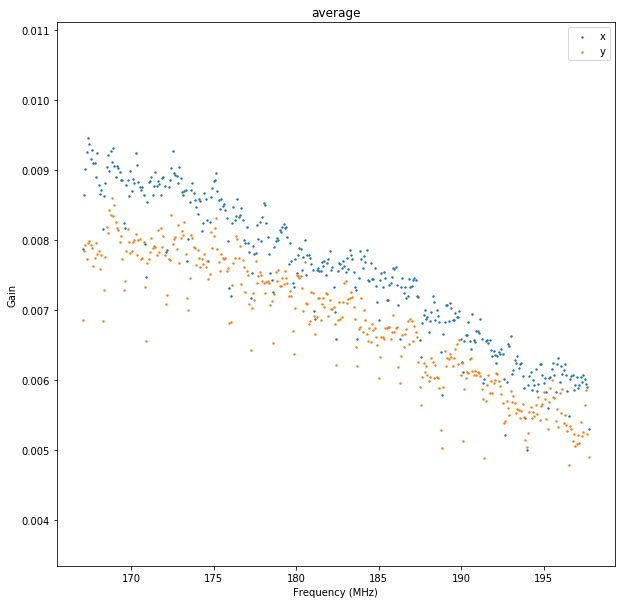

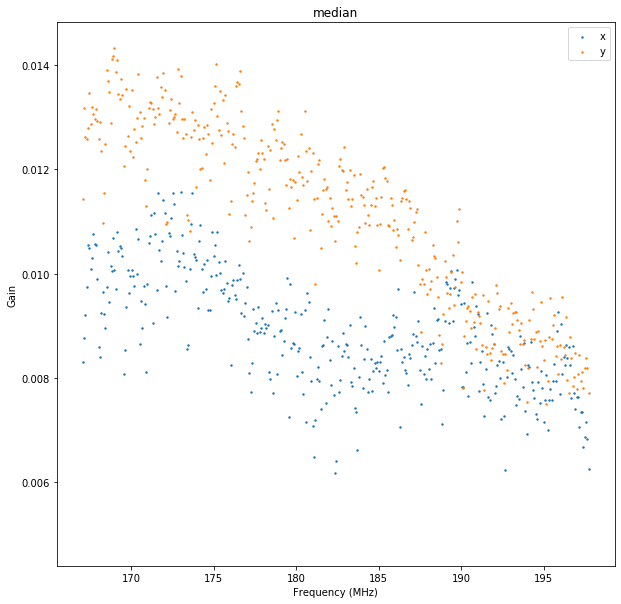

In [13]:
polnames = uvutils.jnum2str(calobj.jones_array)

plt.figure(figsize=(10,10))

plt.scatter(freq_array_mhz, mean_bandpass[:,0], label=polnames[0][-1], marker="o", s=2)
plt.scatter(freq_array_mhz, mean_bandpass[:,1], label=polnames[1][-1], marker="o", s=2)
titlename = "average"
plt.title(titlename)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Gain")
# plt.ylim(0.015, 0.035)
plt.legend()

plt.figure(figsize=(10,10))

plt.scatter(freq_array_mhz, median_bandpass[:,0], label=polnames[0][-1], marker="o", s=2)
plt.scatter(freq_array_mhz, median_bandpass[:,1], label=polnames[1][-1], marker="o", s=2)
titlename = "median"
plt.title(titlename)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Gain")
# plt.ylim(0.015, 0.035)
plt.legend()



In [8]:
freq_flags = np.squeeze(np.abs(calobj.get_flags(0)))[:, 0]
freq_array_mhz_use = freq_array_mhz[freq_flags == False]
nfreq_use = freq_array_mhz_use.size

amplitude_use = np.squeeze(np.abs(calobj.gain_array))[:, freq_flags == False, :]

degree=8

coeffs = np.zeros((degree+1, calobj.Nants_data, calobj.Njones), dtype=np.float)
fit_values = np.zeros_like(amplitude_use)

tile_freq = np.tile(freq_array_mhz_use, (calobj.Nants_data, 1))
for pol_i in np.arange(2):
    coeffs[:, :, pol_i] = poly.polyfit(
        freq_array_mhz_use, amplitude_use[:, :, pol_i].T, degree
    )
    fit_values[:, :, pol_i] = np.tile(coeffs[0, :, pol_i], (nfreq_use, 1)).T
    for deg in np.arange(degree):
        fit_values[:, :, pol_i] += (
        + tile_freq**(deg+1)*np.tile(coeffs[deg+1, :, pol_i], (nfreq_use, 1)).T
    )

residuals = amplitude_use - fit_values

The fit may be poorly conditioned


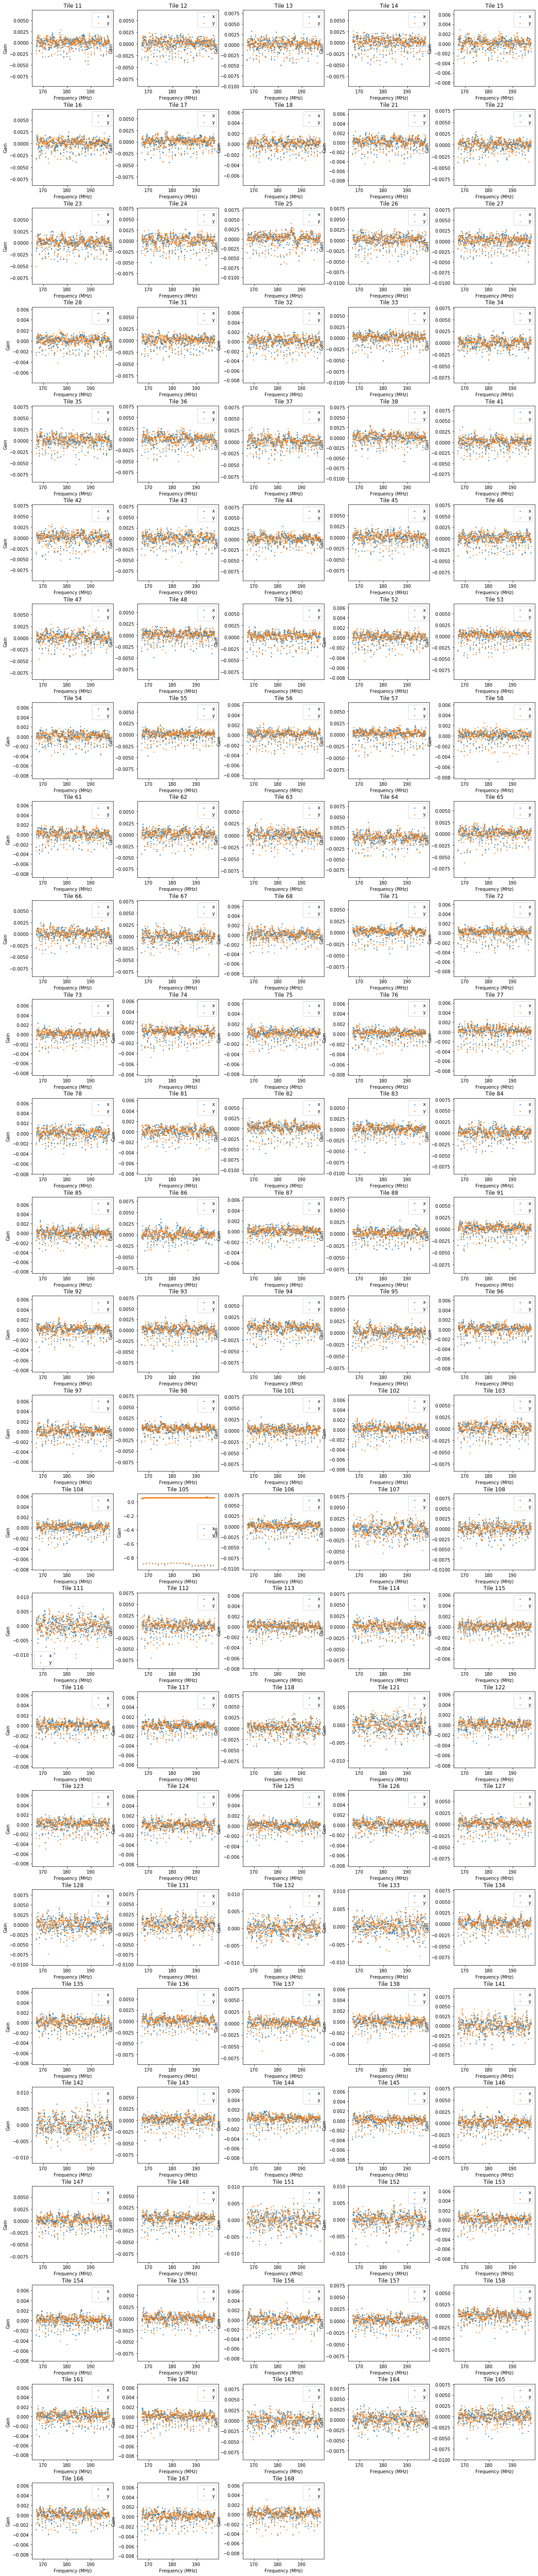

In [9]:
savefig = False

if savefig:
    columns = 10
    rows = np.ceil(calobj.Nants_data / columns)    
else:
    columns = 5
    rows = np.ceil(calobj.Nants_data / columns)
plt.figure(figsize=(4*columns,4*rows))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace = 0.3)
polnames = uvutils.jnum2str(calobj.jones_array)

for ant_num, ant_name in zip(calobj.antenna_numbers, calobj.antenna_names):
    plt.subplot(rows, columns, ant_num+1)
    plt.scatter(
        freq_array_mhz_use, residuals[ant_num, :, 0], label=polnames[0][-1], marker="o", s=2
    )
    plt.scatter(
        freq_array_mhz_use,  residuals[ant_num, :, 1], label=polnames[1][-1], marker="o", s=2
    )

    titlename = 'Tile ' + ant_name.strip()
    plt.title(titlename)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Gain")
#     plt.ylim(0.015, 0.035)
    plt.legend()

if savefig:
    plt.savefig(os.path.join(fhd_folder, obsname + "_uvcal_gains.png"))



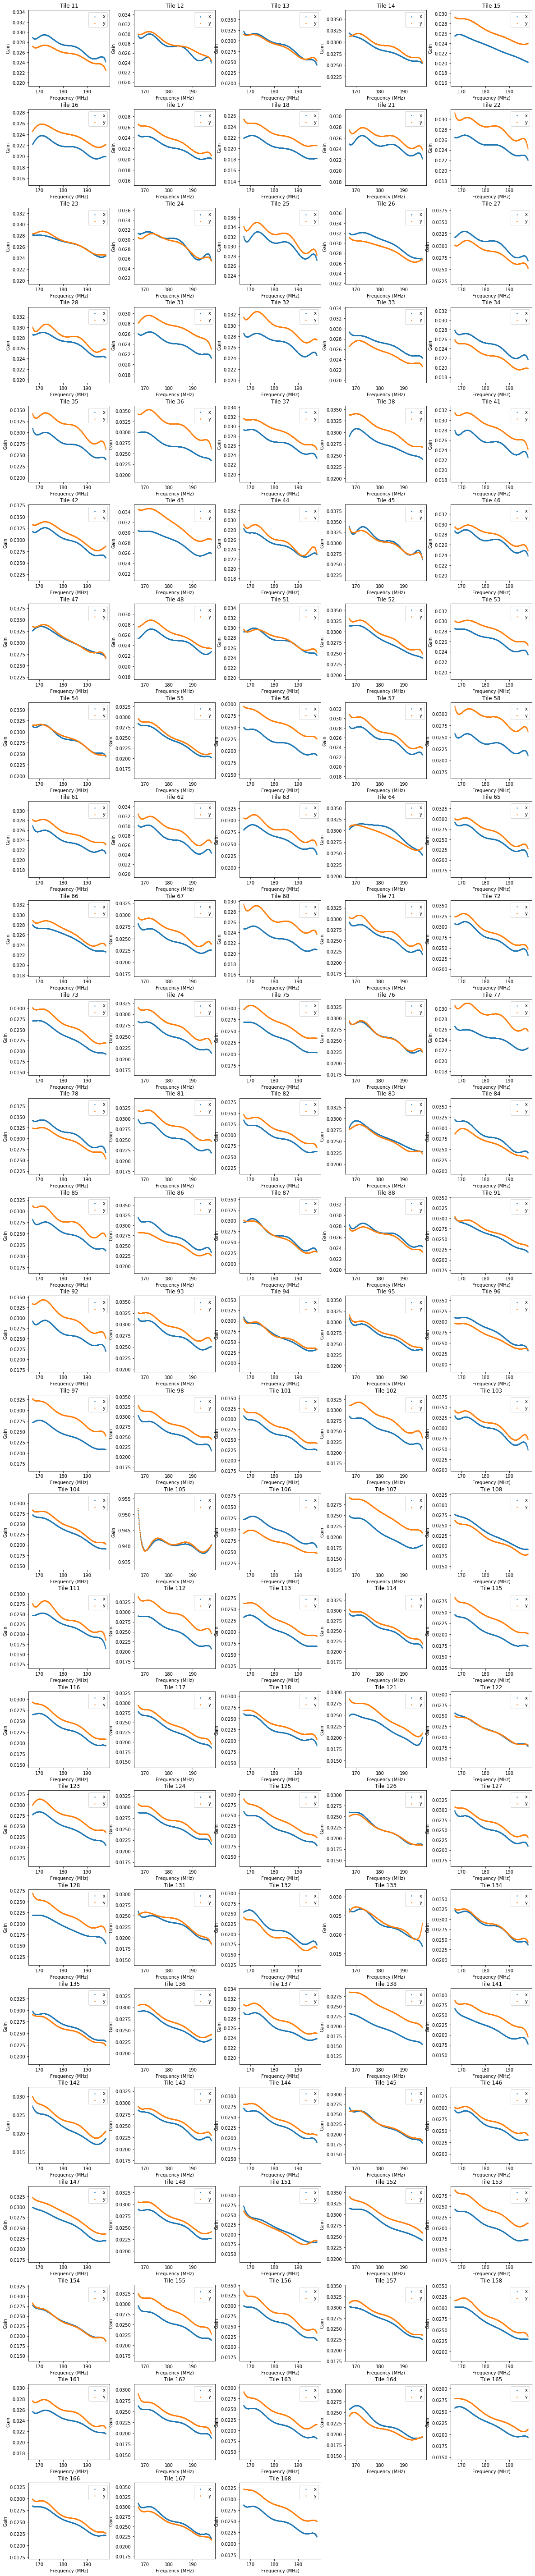

In [10]:
savefig = False

if savefig:
    columns = 10
    rows = np.ceil(calobj.Nants_data / columns)    
else:
    columns = 5
    rows = np.ceil(calobj.Nants_data / columns)
plt.figure(figsize=(4*columns,4*rows))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace = 0.3)
polnames = uvutils.jnum2str(calobj.jones_array)

for ant_num, ant_name in zip(calobj.antenna_numbers, calobj.antenna_names):
    plt.subplot(rows, columns, ant_num+1)
    plt.scatter(
        freq_array_mhz_use, fit_values[ant_num, :, 0], label=polnames[0][-1], marker="o", s=2
    )
    plt.scatter(
        freq_array_mhz_use,  fit_values[ant_num, :, 1], label=polnames[1][-1], marker="o", s=2
    )

    titlename = 'Tile ' + ant_name.strip()
    plt.title(titlename)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Gain")
#     plt.ylim(0.015, 0.035)
    plt.legend()

if savefig:
    plt.savefig(os.path.join(fhd_folder, obsname + "_uvcal_gains.png"))




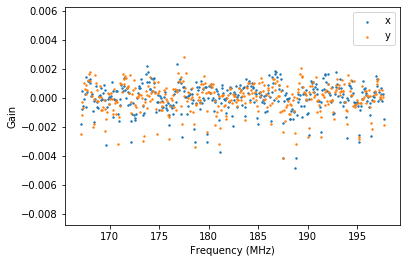

In [15]:
ant_num=0
plt.scatter(
    freq_array_mhz_use, residuals[ant_num, :, 0], label=polnames[0][-1], marker="o", s=2
)
plt.scatter(
    freq_array_mhz_use,  residuals[ant_num, :, 1], label=polnames[1][-1], marker="o", s=2
)

# titlename = 'Tile ' + ant_name.strip()
# plt.title(titlename)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Gain")
#     plt.ylim(0.015, 0.035)
plt.legend()

